In [37]:
from visualiser import plot_ims
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import utils
from hlt import *
import math
import random
import numpy as np

In [2]:
with open('dumps/gameMap_smartfrontier_120','rb') as f:
    myID,gameMap = pickle.load(f)

In [3]:
def attractiveness(site):
    return (255.-site.strength)/255 + site.production/30.

def map_attractiveness(myID,gameMap):
    for y in range(gameMap.height):
        for x in range(gameMap.width):
            loc = Location(x,y)
            site = gameMap.getSite(loc)
            if site.owner == myID:
                site.attractiveness = -999
            else:
                site.attractiveness = attractiveness(site)
            site.potential_attr = site.attractiveness

def map_potential_attr(frontier,myID,gameMap,visited_set=None,decay=0.1):
    if not frontier:
        return
    if visited_set is None:
        visited_set = frontier
    new_frontier = set()
    for loc in frontier:
        site = gameMap.getSite(loc)
        for d in CARDINALS:
            new_loc = gameMap.getLocation(loc,d)
            new_site = gameMap.getSite(new_loc)
            if new_site.owner != myID or new_loc in visited_set:
                continue
            new_site.potential_attr = max(site.potential_attr-decay,new_site.potential_attr)
            new_frontier.add(new_loc)
    visited_set.update(new_frontier)
    map_potential_attr(new_frontier,myID,gameMap,visited_set=visited_set,decay=decay)

def attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.5):
    potential = gameMap.getSite(loc,d).potential_attr
    inv_d = utils.invert_direction(d)
    if d == momentumMap[loc]:
        momentum = momentumTerm
    elif inv_d == momentumMap[loc]:
        momentum = -momentumTerm
    else:
        momentum = 0.
    return potential + momentum

def map_directions(myID,gameMap,momentumMap,momentumTerm=0.5):
    for y in range(gameMap.height):
        for x in range(gameMap.width):
            loc = Location(x,y)
            site = gameMap.getSite(loc)
            if site.owner!=myID:
                site.direction=None
                site.potential_direction=None
                continue
            site.potential_direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.))
            site.direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=momentumTerm))

def adjust_frontier_potential(frontier,myID,gameMap,turn,enemy_attr=1.):
    for loc in frontier:
        site = gameMap.getSite(loc)
        for d in CARDINALS:
            newsite = gameMap.getSite(loc,d)
            if newsite.owner not in (0,myID):
                site.potential_attr += enemy_attr
                
def get_inner_frontier(frontier,myID,gameMap):
    inner_frontier = set()
    for loc in frontier:
        site = gameMap.getSite(loc)
        for d in CARDINALS:
            new_loc = gameMap.getLocation(loc,d)
            new_site = gameMap.getSite(new_loc)
            if new_site.owner != myID or new_loc in frontier:
                continue
            inner_frontier.add(new_loc)
            new_site.is_inner_frontier = True
    return inner_frontier

def smooth_inner_frontier(frontier,myID,gameMap):
    for loc in frontier:
        neighbors_potential_attr = [gameMap.getSite(loc,d).potential_attr for d in HALFCARDINALS if gameMap.getLocation(loc,d) in frontier]
        site = gameMap.getSite(loc)
        all_potentials = [site.potential_attr]+neighbors_potential_attr
        site.potential_attr_temp =  sum(all_potentials)/len(all_potentials)
    for loc in frontier:
        site = gameMap.getSite(loc)
        site.potential_attr =  site.potential_attr_temp

In [7]:
decay = 0.1
map_attractiveness(myID,gameMap)
frontier = utils.find_frontier(myID,gameMap)
map_potential_attr(set(frontier),myID,gameMap,decay=decay)
map_directions(myID,gameMap)

TypeError: map_directions() takes at least 3 arguments (2 given)

In [5]:
momentumMap = {Location(x,y):0 for x in range(gameMap.width) for y in range(gameMap.height)}

In [82]:
frontier = set(utils.find_frontier(myID,gameMap))

In [17]:
len(frontier)

39

In [41]:
np.random.choice([1,2,3],p=[0.5,1.6,3.])

ValueError: probabilities do not sum to 1

In [19]:
locslist = [(x,y,Location(x,y)) for x in range(gameMap.width) for y in range(gameMap.height)]
locsmap = {(x,y):Location(x,y) for x in range(gameMap.width) for y in range(gameMap.height)}
locsmap_d = {(loc,d):gameMap.getLocation(loc,d) for x,y,loc in locslist for d in DIRECTIONS}
locsites = {(loc,d):gameMap.getSite(loc,d) for x,y,loc in locslist for d in DIRECTIONS}

In [30]:
def map_inner_attr(frontier,inner_locs,iterations = 10, decay = 0.1):
    potentials = {loc:-999 for loc in inner_locs}
    directions = {loc:0 for loc in inner_locs}
    for loc in frontier:
        potentials[loc] = locsites[(loc,0)].potential_attr
    for _ in range(iterations):
        for loc in inner_locs:
            potentials[loc],directions[loc] = max([(potentials[locsmap_d[(loc,d)]] - decay,d) for d in CARDINALS])
    for loc in inner_locs:
        locsites[(loc,0)].potential_attr = potentials[loc]
        locsites[(loc,0)].direction = directions[loc]
        

In [140]:
def map_inner_attr_rand(frontier,inner_locs,steps=10,iterations=100):
    frontier_list = list(frontier)
    n_visits = {loc:0 for loc in inner_locs}
    inner_set = set(inner_locs)
    possible_directions = {loc:set([d for d in CARDINALS if locsmap_d[(loc,d)] in inner_set]) for loc in frontier_list+inner_locs}
    frontier_potentials = [locsites[(loc,0)].potential_attr for loc in frontier_list]
    scaling_factor = float(sum(frontier_potentials))
    max_potential = max(frontier_potentials)
    frontier_potentials = [fp/scaling_factor for fp in frontier_potentials]
    
    for _ in range(iterations):
        current = np.random.choice(frontier_list,p=frontier_potentials)
        d = 0
        visited = set()
        for step in range(steps):
            try:
                d = np.random.choice(possible_directions[current].difference([inverted_dirs[d]]))
            except ValueError:
                d = np.random.choice(list(possible_directions[current]))
            if locsmap_d[(current,d)] in visited:
                continue
            current = locsmap_d[(current,d)]
            n_visits[current]+=1
            visited.add(current)
            
    total_visits = float(steps*iterations)
    for loc in inner_locs:
        locsites[(loc,0)].potential_attr = n_visits[loc]/total_visits*scaling_factor
    for loc in inner_locs:
        locsites[(loc,0)].direction = max([d for d in CARDINALS],key=lambda d_:locsites[(loc,d_)].potential_attr)


In [130]:
inverted_dirs = {1:3,2:4,3:1,4:2,0:0}

In [123]:
s = set([1,2,3])

In [121]:
s.discard(3)

In [122]:
s.

{1, 2}

In [70]:
%timeit np.random.choice([1,2,3,4])

The slowest run took 6.57 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.62 µs per loop


In [71]:
d = {1:0}

In [76]:
%timeit x = random.random()

The slowest run took 49.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 221 ns per loop


In [99]:
%timeit map_inner_attr_rand(frontier,inner_locs,steps=10,iterations=500)

1 loop, best of 3: 143 ms per loop


In [35]:
%timeit map_inner_attr(frontier,inner_locs,iterations = 100, decay = 0.1)

10 loops, best of 3: 117 ms per loop


In [ ]:
locsites

In [64]:
min_potential = min([locsites[(loc,0)].potential_attr for loc in frontier])
for loc in frontier:
    locsites[(loc,0)].potential_attr -= 2* min_potential

In [115]:
locsites[(list(frontier)[20],0)].potential_attr = 100.
[locsites[(loc,0)].potential_attr for loc in frontier]

[3.219607843137255,
 3.011764705882353,
 3.1215686274509804,
 2.992156862745098,
 3.1098039215686275,
 3.350980392156863,
 3.3588235294117648,
 3.4039215686274513,
 3.264705882352941,
 3.1411764705882357,
 3.1843137254901963,
 3.088235294117647,
 3.066666666666667,
 3.1352941176470592,
 3.0647058823529414,
 2.9901960784313726,
 3.096078431372549,
 2.7529411764705882,
 3.4294117647058826,
 3.3784313725490196,
 100.0,
 3.327450980392157,
 3.143137254901961,
 3.0784313725490198,
 3.376470588235294,
 3.1235294117647063,
 3.3098039215686277,
 3.354901960784314,
 3.3333333333333335,
 3.2,
 2.9529411764705884,
 2.9941176470588236,
 3.219607843137255,
 3.1176470588235294,
 3.327450980392157,
 2.686274509803922,
 3.343137254901961,
 3.1882352941176473,
 5.0]

In [ ]:
for x in range(gameMap.width):
    for y in range(gameMap.height):
        loc = Location(x,y)
        if loc not in frontier:
            gameMap.getSite(loc).potential_attr = 0

inner_locs = [loc for x,y,loc in locslist if locsites[(loc,0)].owner==myID]
# map_inner_attr(frontier,inner_locs,iterations = 10, decay = 0.1)
map_inner_attr_rand(frontier,inner_locs,steps=10,iterations=500)

state = {
    'heat':'potential_attr',
    'arrows':'direction'
}

plt.figure(figsize=(10,10))
_ = plot_ims(gameMap,state)

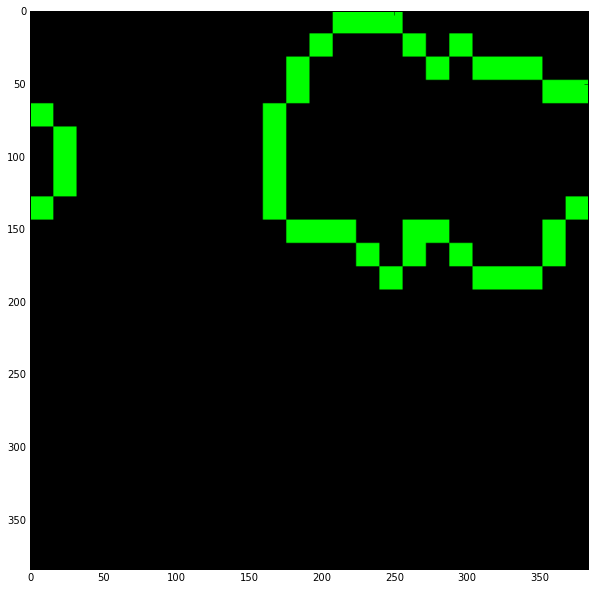

In [52]:
decay = 0.3
momentumTerm = 0.

#frontier = set(utils.frontier_tracking(frontier,myID,gameMap))
frontier = set(utils.find_frontier(myID,gameMap))

inner_frontier = get_inner_frontier(frontier,myID,gameMap)

map_attractiveness(myID,gameMap)

#adjust_frontier_potential(frontier,myID,gameMap,turn,enemy_attr=enemy_attr)

#smooth_inner_frontier(inner_frontier,myID,gameMap)
#smooth_inner_frontier(inner_frontier,myID,gameMap)
#smooth_inner_frontier(inner_frontier,myID,gameMap)
#smooth_inner_frontier(inner_frontier,myID,gameMap)

map_potential_attr(frontier,myID,gameMap,decay=decay)

#smooth_inner_frontier(inner_frontier,myID,gameMap)

#map_potential_attr(frontier,myID,gameMap,decay=decay)

map_directions(myID,gameMap,momentumMap,momentumTerm=momentumTerm)

state = {
    'arrows':'direction',
    'color':'is_frontier'
}

plt.figure(figsize=(10,10))
_ = plot_ims(gameMap,state)

In [60]:
locsmap = {(x,y):Location(x,y) for x in range(gameMap.width) for y in range(gameMap.height)}

In [65]:
locsites = {loc:gameMap.getSite(loc) for loc in locsmap.values()}

In [72]:
locsites_d = {(loc,d):gameMap.getSite(loc,d) for loc in locsmap.values() for d in CARDINALS}

In [77]:
%timeit {(loc,d):gameMap.getSite(loc,d) for loc in locsmap.values() for d in CARDINALS}

10 loops, best of 3: 33.4 ms per loop


In [80]:
%timeit gameMap.getSite(loc)

The slowest run took 7.06 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.48 µs per loop


In [75]:
def attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.5):
    potential = locsites_d[(loc,d)].potential_attr
    inv_d = utils.invert_direction(d)
    # if d == momentumMap[loc]:
    #     momentum = momentumTerm
    if inv_d == momentumMap[loc]:
        momentum = -momentumTerm
    else:
        momentum = 0.
    return potential + momentum

def map_directions(myID,gameMap,momentumMap,momentumTerm=0.5):
    for y in range(gameMap.height):
        for x in range(gameMap.width):
            loc = locsmap[(x,y)]
            #loc = Location(x,y)
            #site = gameMap.getSite(loc)
            site = locsites[loc]
            if site.owner!=myID:
                site.direction=None
                #site.potential_direction=None
                continue
            # site.potential_direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=0.))
            #momentum_d = momentumMap[loc]
            
            site.direction = max(CARDINALS,key=lambda d:attr_direction(loc,d,gameMap,momentumMap,momentumTerm=momentumTerm))

In [50]:
%timeit map_directions(myID,gameMap,momentumMap)

10 loops, best of 3: 20.2 ms per loop


In [52]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 8.14 ms per loop


In [54]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 8.22 ms per loop


In [56]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 52.77 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 17.8 µs per loop


In [58]:
%timeit map_directions(myID,gameMap,momentumMap)

1000 loops, best of 3: 274 µs per loop


In [62]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 8.07 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 87.2 µs per loop


In [64]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 7.89 ms per loop


In [67]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 6.02 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 377 µs per loop


In [69]:
%timeit map_directions(myID,gameMap,momentumMap)

The slowest run took 5.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 458 µs per loop


In [71]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 12.3 ms per loop


In [76]:
%timeit map_directions(myID,gameMap,momentumMap)

100 loops, best of 3: 2.2 ms per loop
